# AdventureWorks Försäljningsanalys
I denna analys undersöker vi AdventureWorks-databasen för att besvara affärsfrågor som exempelvis:
- Produktkategorier och deras försäljning
- Försäljningstrender över tid
- Regional försäljning

Vi använder SQL för att hämta data och Python för visualisering och analys.

In [1]:
import os
from dotenv import load_dotenv
load_dotenv()
if not os.getenv("DB_PASSWORD"):
    raise ValueError("DB_PASSWORD is not set. Check that your .env file exists and is loaded.")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine, text
from urllib.parse import quote_plus
import warnings
from sqlalchemy.exc import SAWarning

warnings.filterwarnings("ignore", category=SAWarning)

user = "sa"
password = quote_plus(os.getenv("DB_PASSWORD"))
server = "127.0.0.1,1434"
database = "AdventureWorks2025"
driver = quote_plus("ODBC Driver 18 for SQL Server")

connection_string = (
    f"mssql+pyodbc://{user}:{password}@{server}/{database}"
    f"?driver={driver}&Encrypt=yes&TrustServerCertificate=yes"
)

engine = create_engine(connection_string)

try:
    with engine.connect():
        print("Anslutning till SQL Server lyckades")
except Exception as e:
    print("Kunde inte ansluta:", e)


Anslutning till SQL Server lyckades


In [2]:
def query_df(sql: str):
    with engine.connect() as conn:
        return pd.read_sql(text(sql), conn)


## Visualisering 1: Antal produkter per kategori 
#### Hur många produkter finns i varje kategori?

**Tabeller som används:**
- `Production.ProductCategory`
- `Production.ProductSubcategory`
- `Production.Product`

**Plan:**
1. Joina tabellerna
2. Räkna unika produkter per kategori
3. Skapa ett vertikalt stapeldiagram
4. Analysera resultatet

**Tillägg:**
- Analysera subkategorin *Components*

In [3]:
sql_products_per_category = """ 
SELECT pc.name AS Kategori, COUNT(DISTINCT p.ProductID) AS Antal_Produkter
FROM production.productcategory pc   
JOIN production.productsubcategory psc
    ON pc.productcategoryid = psc.productcategoryid
JOIN production.product p
    ON psc.productsubcategoryid = p.productsubcategoryid
GROUP BY pc.name  
ORDER BY Antal_Produkter DESC;
"""  

In [4]:
df_products_per_category = query_df(sql_products_per_category)
df_products_per_category

,Kategori,Antal_Produkter
0,Components,134
1,Bikes,97
2,Clothing,35
3,Accessories,29


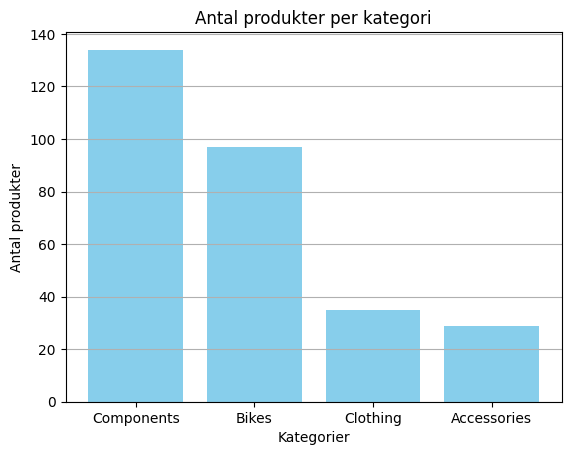

In [5]:
fig, ax =plt.subplots()
ax.bar(df_products_per_category['Kategori'], df_products_per_category['Antal_Produkter'], color='skyblue')
ax.set_title("Antal produkter per kategori")
ax.set_xlabel("Kategorier")
ax.set_ylabel("Antal produkter")
ax.grid(True, axis='y')
plt.show()

In [6]:
sql_products_per_subcategory = """ 
SELECT psc.name AS Underkategori, COUNT(p.ProductID) AS Antal_Produkter  
FROM production.productcategory pc   
JOIN production.productsubcategory psc
    ON pc.productcategoryid = psc.productcategoryid
JOIN production.product p
    ON psc.productsubcategoryid = p.productsubcategoryid
WHERE pc.Name = 'Components'
GROUP BY psc.Name
ORDER BY Antal_Produkter DESC;
"""  

In [7]:
df_products_per_subcategory = query_df(sql_products_per_subcategory)
df_products_per_subcategory

,Underkategori,Antal_Produkter
0,Road Frames,33
1,Mountain Frames,28
2,Touring Frames,18
3,Wheels,14
4,Saddles,9
5,Handlebars,8
6,Pedals,7
7,Bottom Brackets,3
8,Cranksets,3
9,Forks,3


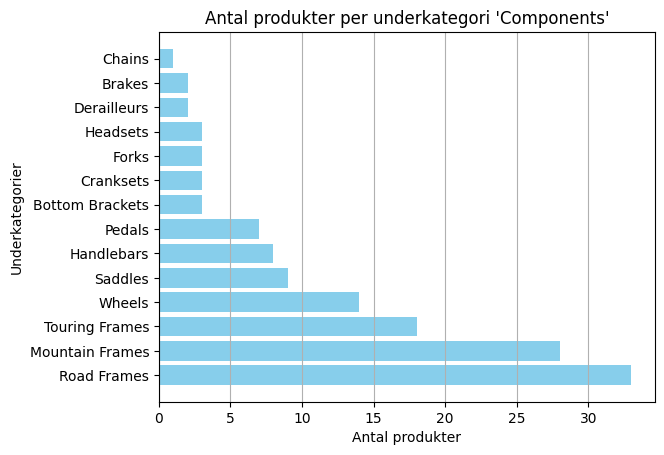

In [8]:
fig, ax =plt.subplots()
ax.barh(df_products_per_subcategory['Underkategori'], df_products_per_subcategory['Antal_Produkter'], color='skyblue')
ax.set_title("Antal produkter per underkategori 'Components'")
ax.set_xlabel("Antal produkter")
ax.set_ylabel("Underkategorier")
ax.grid(True, axis='x')
plt.show()

## Insikter - Antal produkter per kategori 
Flest antal enskilda produker finns inom kategorin 'Components', med 134 olika produkter. Företagets produktkatelog domineras därför av komponenter och reservdelar. Då kategorin 'Components' är väldigt bred har vi valt att titta närmare på dess subkategorier. Då ser vi att 'frames' (ramar) är den produktgrupp med flest unika produkter i vårt sortiment. 'Road frames' har flest unika produkter, följt av 'mountain frames' och 'touring frames'. Vi kan konstatera att med 79 unika produkter utgör cykelramar över hälften av alla produkter i 'Components'. 

## Visualisering 2: Försäljning per produktkategori
#### Vilka produktkategorier genererar mest intäkter?

**Tabeller som används:**
- `Production.ProductCategory`
- `Production.ProductSubcategory`
- `Production.Product`
- `Sales.SalesOrderDetail`

**Plan:**
1. Joina tabellerna
2. Ta fram intäkt per kategori genom att använda LineTotal som tar 
kvantitet * pris, inklusive rabatter
3. Skapa ett horizontellt stapeldiagram
4. Analysera resultatet

**Tillägg:**
- Analysera subkategorin *Bikes*

In [9]:
sql_revenue_per_category = """ 
SELECT pc.name AS Kategori, SUM(sod.LineTotal) AS Intäkt -- LineTotal är i formatet MONEY, inkluderar rabatter
FROM production.productcategory pc   
JOIN production.productsubcategory psc
    ON pc.productcategoryid = psc.productcategoryid
JOIN production.product p
    ON psc.productsubcategoryid = p.productsubcategoryid
JOIN sales.salesorderdetail sod  
    ON p.productid = sod.productid
GROUP BY pc.name  
ORDER BY Intäkt DESC;
"""

In [10]:
df_revenue_per_category = query_df(sql_revenue_per_category)
df_revenue_per_category


,Kategori,Intäkt
0,Bikes,9.465117e+07
1,Components,1.180259e+07
2,Clothing,2.120543e+06
3,Accessories,1.272073e+06


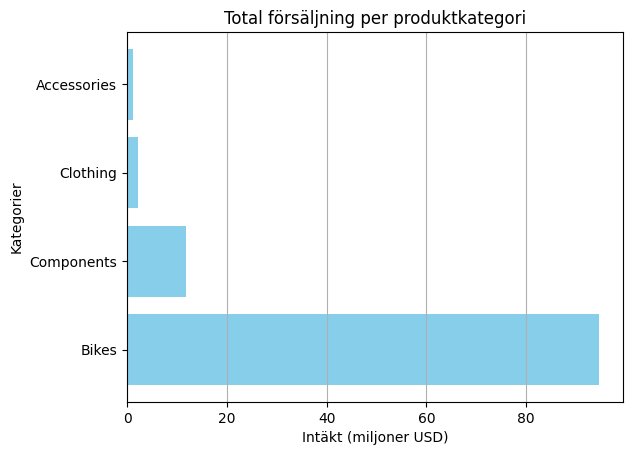

In [11]:
fig, ax =plt.subplots()
revenue_millions = df_revenue_per_category['Intäkt'] / 1_000_000
ax.barh(df_revenue_per_category['Kategori'], revenue_millions, color='skyblue')
ax.set_title("Total försäljning per produktkategori")
ax.set_xlabel("Intäkt (miljoner USD)")
ax.set_ylabel("Kategorier")
ax.grid(True, axis='x')
plt.show()

In [12]:
sql_revenue_per_subcategory = """ 
SELECT psc.name AS Underkategori, SUM(sod.LineTotal) AS Intäkt
FROM production.productcategory pc   
JOIN production.productsubcategory psc
    ON pc.productcategoryid = psc.productcategoryid
JOIN production.product p
    ON psc.productsubcategoryid = p.productsubcategoryid
JOIN sales.salesorderdetail sod  
    ON p.productid = sod.productid
WHERE pc.Name = 'Bikes'
GROUP BY psc.Name
ORDER BY Intäkt DESC;
"""

In [13]:
df_revenue_per_subcategory = query_df(sql_revenue_per_subcategory)
df_revenue_per_subcategory

,Underkategori,Intäkt
0,Road Bikes,4.390944e+07
1,Mountain Bikes,3.644544e+07
2,Touring Bikes,1.429629e+07


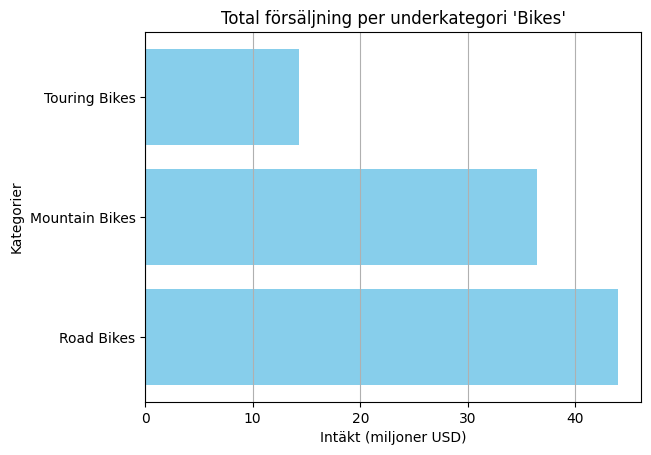

In [14]:
fig, ax =plt.subplots()
revenue_millions = df_revenue_per_subcategory['Intäkt'] / 1_000_000
ax.barh(df_revenue_per_subcategory['Underkategori'], revenue_millions, color='skyblue')
ax.set_title("Total försäljning per underkategori 'Bikes'")
ax.set_xlabel("Intäkt (miljoner USD)")
ax.set_ylabel("Kategorier")
ax.grid(True, axis='x')
plt.show()

## Insikter - Intäkt per kategori 
Kategorin 'Bikes' är helt klart företagets viktigaste inkomstkälla, med en intäkt på USD 94,651,172 under den relevanta perioden. (Jag gör här ett antagande att försäljningspriset är i USD då tex adresser i databasen är i USA.) Det är åtta gånger mer än de totala intäkterna för kategorin 'Components' på USD 11,802,593. Därefter följer kategorin 'Clothing' på USD 2,120,542 och 'Accessories' med USD 1,272,072.

Då företagets försäljning domineras så kraftigt av cyklar har vi valt att titta närmare på denna kategori. Vi fann att 'Road Bikes' genererade intäkter på USD 44 miljoner under den relevanta perioden, en underkategori som alltså stod för ca 40 % av företagets totala intäkter på USD 110 miljoner, baserad på samtliga orderrader i databasen. 'Mountain Bike' kategorin följs tätt efter med USD 36 miljoner. 

Sett till intäkter är därför 'Road Bikes' och 'Mountain Bikes' de viktigare produktkategorierna för företaget. Dock har vi ännu inte analyserat vinstmarginalerna på dessa produkter och kan därför inte uttala oss om vad det är som är viktigast för företgaets vinst. Vi har heller inte gjort någon tidsavgränsning för analysen, utan har inkluderat all tillgänglig försäljningsdata, vilket också kan vara missvisande i avsaknad av jämförelse mellan olika rapporteringsperioder. 

## Visualisering 3: Försäljning över tid
#### Hur har försäljningen utvecklats över tid?

**Tabeller som används:**
- `Sales.SalesOrderHeader`
- `Sales.SalesOrderDetail` 
- `Production.Product` 
- `Production.ProductSubcategory` 
- `Production.ProductCategory`

**Plan:**
1. Aggregera per månad (minst 12 månader data)
2. Sortera kronologiskt (äldst först) 
2. Ta fram intäkt per kategori genom att använda SubTotal som är
exklusivt frakt och skatt
3. Skapa ett linjediagram
4. Analysera resultatet

**Tillägg:**
- Analysera försäljning och ordrar i Q2 2025
- Analysera subkategorierna  *Components* och *Bikes*

In [15]:
sql_revenue_per_month = """
SELECT
  YEAR(soh.OrderDate) AS År,                --- OrderDate format datetime ---
  MONTH(soh.OrderDate) AS Månad,
  SUM(soh.SubTotal) AS Försäljning          --- använd SubTotal då den inte innehåller skatt eller frakt ---
FROM Sales.SalesOrderHeader AS soh
GROUP BY YEAR(soh.OrderDate), MONTH(soh.OrderDate)
ORDER BY År, Månad ASC;
""" 
 

In [16]:
df_revenue_per_month = query_df(sql_revenue_per_month)


In [17]:
# Kombinerar år och månad och skapar en ny kolumn 'Datum', så att vi kan visa det på en tidslinje / x-axeln
df_revenue_per_month['Datum'] = pd.to_datetime(
    dict(
        year=df_revenue_per_month['År'],
        month=df_revenue_per_month['Månad'],
        day=1                       #Sätter dagen som första dagen i månaden
    )
)

In [18]:
df_revenue_per_month = df_revenue_per_month[
    (df_revenue_per_month['Datum'] >= '2022-06-01') &   #Då maj 2022 inte är en fullständig månad
    (df_revenue_per_month['Datum'] <= '2025-05-30')     #Då juni 2025 inte är en fullständig månad
]


In [19]:
# Hitta min och max värden
df_extremes = df_revenue_per_month.loc[                
    [
        df_revenue_per_month['Försäljning'].idxmax(),
        df_revenue_per_month['Försäljning'].idxmin()
    ],
    ['Datum', 'Försäljning']
].copy()


In [20]:
df_extremes['Typ'] = ['Högsta månad', 'Lägsta månad']

df_extremes['Försäljning (miljoner USD)'] = (
    df_extremes['Försäljning'] / 1_000_000
).round(2)

df_extremes[['Datum', 'Typ', 'Försäljning (miljoner USD)']]


,Datum,Typ,Försäljning (miljoner USD)
35,2025-04-01,Högsta månad,5.22
3,2022-08-01,Lägsta månad,1.33


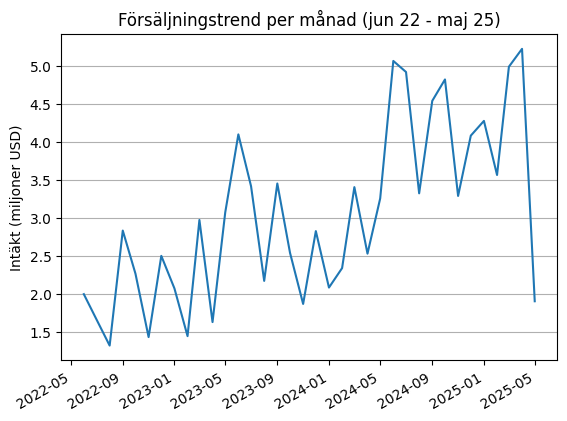

In [21]:
fig, ax =plt.subplots()
revenue_per_month = df_revenue_per_month['Försäljning'] / 1_000_000
ax.plot(df_revenue_per_month['Datum'], revenue_per_month)
ax.set_title("Försäljningstrend per månad (jun 22 - maj 25)")
ax.set_ylabel("Intäkt (miljoner USD)")
ax.grid(True, axis='y')
fig.autofmt_xdate()
plt.show()

In [22]:
sql_revenue_Q2 = """
SELECT
  YEAR(soh.OrderDate) AS År,
  MONTH(soh.OrderDate) AS Månad,
  pc.Name AS Kategori,
  SUM(sod.LineTotal) AS Intäkt
FROM Sales.SalesOrderHeader soh
JOIN Sales.SalesOrderDetail sod ON soh.SalesOrderID = sod.SalesOrderID
JOIN Production.Product p ON sod.ProductID = p.ProductID
JOIN Production.ProductSubcategory psc ON p.ProductSubcategoryID = psc.ProductSubcategoryID
JOIN Production.ProductCategory pc ON psc.ProductCategoryID = pc.ProductCategoryID
WHERE soh.OrderDate >= '2025-04-01'
  AND soh.OrderDate <  '2025-07-01'
GROUP BY YEAR(soh.OrderDate), MONTH(soh.OrderDate), pc.Name
ORDER BY År, Månad, Intäkt DESC;
"""

In [23]:
df_revenue_Q2 = query_df(sql_revenue_Q2)
df_revenue_Q2

,År,Månad,Kategori,Intäkt
0,2025,4,Bikes,4.423690e+06
1,2025,4,Components,5.778524e+05
2,2025,4,Clothing,1.143858e+05
3,2025,4,Accessories,1.068310e+05
4,2025,5,Bikes,1.806581e+06
5,2025,5,Accessories,6.602412e+04
6,2025,5,Clothing,3.545401e+04
7,2025,6,Accessories,3.159132e+04
8,2025,6,Clothing,1.590023e+04


In [24]:
sql_bikerevenue_per_month = """ 
SELECT
  YEAR(soh.OrderDate) AS År,
  MONTH(soh.OrderDate) AS Månad,
  SUM(sod.LineTotal) AS Cykelförsäljning
FROM Sales.SalesOrderHeader soh
JOIN Sales.SalesOrderDetail sod
  ON soh.SalesOrderID = sod.SalesOrderID
JOIN Production.Product p
  ON sod.ProductID = p.ProductID
JOIN Production.ProductSubcategory psc
  ON p.ProductSubcategoryID = psc.ProductSubcategoryID
JOIN Production.ProductCategory pc
  ON psc.ProductCategoryID = pc.ProductCategoryID
WHERE pc.Name = 'Bikes'
GROUP BY YEAR(soh.OrderDate), MONTH(soh.OrderDate)
ORDER BY År, Månad;
"""
sql_componentrevenue_per_month = """
SELECT
  YEAR(soh.OrderDate) AS År,
  MONTH(soh.OrderDate) AS Månad,
  SUM(sod.LineTotal) AS Komponentförsäljning
FROM Sales.SalesOrderHeader soh
JOIN Sales.SalesOrderDetail sod
  ON soh.SalesOrderID = sod.SalesOrderID
JOIN Production.Product p
  ON sod.ProductID = p.ProductID
JOIN Production.ProductSubcategory psc
  ON p.ProductSubcategoryID = psc.ProductSubcategoryID
JOIN Production.ProductCategory pc
  ON psc.ProductCategoryID = pc.ProductCategoryID
WHERE pc.Name = 'Components'
GROUP BY YEAR(soh.OrderDate), MONTH(soh.OrderDate)
ORDER BY År, Månad;
""" 

In [25]:
df_bikerevenue_per_month = query_df(sql_bikerevenue_per_month)
df_componentrevenue_per_month = query_df(sql_componentrevenue_per_month)

# Kombinerar år och månad och skapar en ny kolumn 'Datum', så att vi kan visa det på en tidslinje / x-axeln
df_bikerevenue_per_month['Datum'] = pd.to_datetime(
    dict(
        year=df_bikerevenue_per_month['År'],
        month=df_bikerevenue_per_month['Månad'],
        day=1                       #Sätter dagen som första dagen i månaden
    )
)

df_componentrevenue_per_month['Datum'] = pd.to_datetime(
    dict(
        year=df_componentrevenue_per_month['År'],
        month=df_componentrevenue_per_month['Månad'],
        day=1                       #Sätter dagen som första dagen i månaden
    )
)

df_bikerevenue_per_month = df_bikerevenue_per_month[
    (df_bikerevenue_per_month['Datum'] >= '2022-06-01') &   #Då maj 2022 inte är en fullständig månad
    (df_bikerevenue_per_month['Datum'] <= '2025-05-30')     #Då juni 2025 inte är en fullständig månad
]

df_componentrevenue_per_month = df_componentrevenue_per_month[
    (df_componentrevenue_per_month['Datum'] >= '2022-06-01') &   #Då maj 2022 inte är en fullständig månad
    (df_componentrevenue_per_month['Datum'] <= '2025-05-30')     #Då juni 2025 inte är en fullständig månad
]


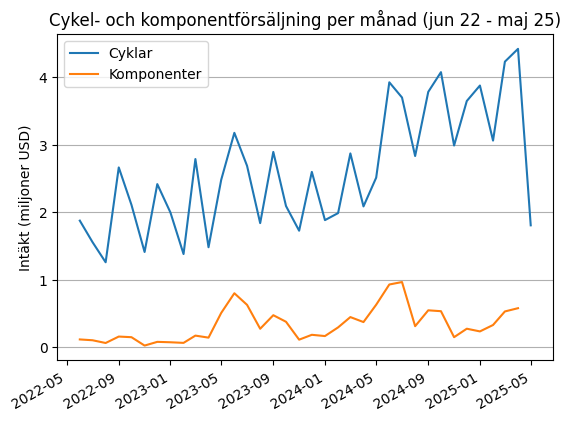

In [26]:
fig, ax =plt.subplots()
bikerevenue_per_month = df_bikerevenue_per_month['Cykelförsäljning'] / 1_000_000
componentrevenue_per_month= df_componentrevenue_per_month['Komponentförsäljning'] / 1_000_000

ax.plot(df_bikerevenue_per_month['Datum'], bikerevenue_per_month, label='Cyklar')
ax.plot(df_componentrevenue_per_month['Datum'], componentrevenue_per_month, label='Komponenter')

ax.set_title("Cykel- och komponentförsäljning per månad (jun 22 - maj 25)")
ax.set_ylabel("Intäkt (miljoner USD)")
ax.grid(True, axis='y')
ax.legend()
fig.autofmt_xdate()
plt.show()

## Insikter - Försäljning över tid
Efter att analyserat den tillgängliga försäljningsdatan i databasen ser vi att vi har tillgång till data från slutet av maj 2022 och fram till slutet av juni 2025. Dock har vi inte data för alla dagarna i dessa månader, antagligen därför att företaget startades upp i maj 2022 och att den kopia av databasen som vi arbetar med togs den 30e juni 2025 och därför enbart inkluderar de första 29 dagarna av den månaden. För att göra månadsjämförelsen rättvis har vi därför valt att exkludera dessa två månader från vår analys. 

Vi har även valt att använda kolumnen SubTotal från vår försäljningstabell, då den exkluderar frakt och skatt, de delar av försäljningspriset som inte tillfaller företaget. 

Tittar man på den totala förtsäljningen över de år som vi har data för, kan vi se en stigande försäljningstrend med försäljning under USD 3 miljoner per månad det första året, för att sedan ligga mellan USD 3.5 - 5.0 miljoner per månad det sista året. Den månaden med lägst försäljning var augusti 2022 och den månaden med högst försäljning var april 2025 med försäljning på USD 1.3 miljoner respektive 5.2 miljoner.  

Dock sker det ett dramatiskt fall i intäkterna i maj 2025, då försäljningsvolymen faller från USD 5.2 miljoner under rekordmånanden april 2025 till USD 1.9 miljoner i maj 2025. Och fortsätter till endast USD 0.5 miljoner i juni 2025 (givet den datan vi har för den månaden). I ljuset av denna abrupta förändring måste vi fråga oss vad som har hänt. 
Fallande efterfråga ger sällan sådana här kraftiga svängningar, speciellt inte för ett föregat som AdventureWorks som, även om de är mycket beroende av sin cykelförsäljning, har ett brett sortiment och har påvisat en hälsosam tillväxt över tre år. Istället kan juridiska regleringar (jämför med det svenska företaget Hövding https://www.svt.se/nyheter/lokalt/skane/konkursade-hovdings-hjalmar-saljs-till-utlandskt-foretag) eller ett samanbrott av leveranskedjan orsaka sådana försäljningsfall. 

Vi har därför gått in och gjort en första analys över vad som har förändrats under andra kvartalet 2025.. Det vi kan se är att kategorin 'Components' faller bort i maj 2025 och att även storsäljaren 'Bikes' försvinner i juni 2025. Vi har därför tittat närmare på dess två produktkategorier över tid. Det vi kan se från vårt diagram är att cykelförsäljningen visar en tydligt uppåtgående trend över tre år, för att sedan kollapsa i mitten av 2025. Produktgruppen komponenter har också visat tillväxt under dessa år, även om den inte har varit lika markant som för cyklar, innan ordrana plötsligt upphör i maj 2025. 

Om detta beror på problem med dataimporten från företagets lokala mjukvara eller en extern händelse som påverkat försäljningen kan vi inte svara på nu men detta försäljningsmönster väcker nyfikenhet och ytterligare analys krävs. Skulle försäljningstappet vara verkligt (och inte bero på ett dataproblem) kan konkurs vara nära förestående.


## Visualisering 4: Försäljning och antal ordrar per år
#### Hur ser total försäljning och antal ordrar ut per år?

**Tabeller som används:**
- `Sales.SalesOrderHeader`

**Plan:**
1. Aggregera försäljning och distinkta ordrar per år
2. Använda SubTotal för försäljning, som är exklusivt frakt och skatt
3. Sortera kronologiskt (år 2022 först) 
4. Skapa ett grupperat stapeldiagram
5. Analysera resultatet 


In [27]:
sql_revenue_per_year = """
SELECT
  YEAR(soh.OrderDate) AS År,                --- OrderDate format datetime ---
  SUM(soh.SubTotal) AS Försäljning          --- änvänd SubTotal då den inte innehåller skatt eller frakt ---
FROM Sales.SalesOrderHeader AS soh
GROUP BY YEAR(soh.OrderDate)
ORDER BY År ASC;
""" 

sql_orders_per_year = """ 
SELECT
  YEAR(soh.OrderDate) AS År,                --- OrderDate format datetime ---
  COUNT(DISTINCT soh.SalesOrderNumber) AS Antal_Ordrar   
FROM Sales.SalesOrderHeader AS soh
GROUP BY YEAR(soh.OrderDate)
ORDER BY År ASC;
"""

In [ ]:
df_revenue_per_year = query_df(sql_revenue_per_year)
df_orders_per_year = query_df(sql_orders_per_year)

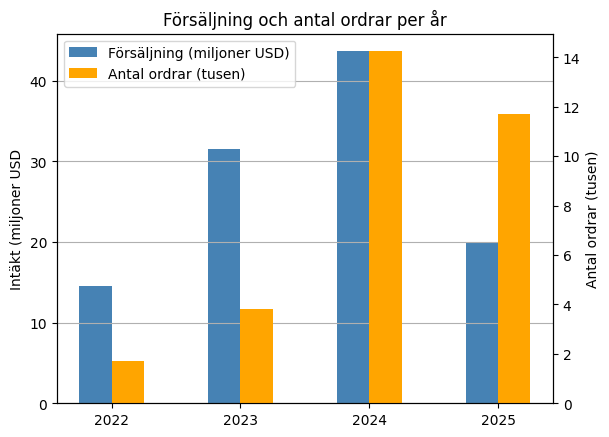

In [35]:
# https://matplotlib.org/stable/gallery/lines_bars_and_markers/barchart.html

years = df_orders_per_year['År'].astype(str).tolist()
sales_m = (df_revenue_per_year['Försäljning'] / 1_000_000).to_numpy()      # miljoner USD
orders_k = (df_orders_per_year['Antal_Ordrar'] / 1_000).to_numpy()        # tusen orderar

x = np.arange(len(years)) 
width = 0.25  # the width of the bars
#multiplier = 0

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()                                                 # för att mäta ordrar

# grouped bars (offset left/right)
ax1.bar(x - width/2, sales_m, width, label="Försäljning (miljoner USD)", color = 'steelblue')
ax2.bar(x + width/2, orders_k, width, label="Antal ordrar (tusen)", color = 'orange')

ax1.set_xticks(x)
ax1.set_xticklabels(years)

ax1.set_ylabel('Intäkt (miljoner USD')
ax2.set_ylabel('Antal ordrar (tusen)')
ax1.set_title('Försäljning och antal ordrar per år')

ax1.grid(True, axis = 'y')

handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles1 + handles2, labels1 + labels2, loc="upper left")

plt.show()